## Observations and Insights 

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata_df = pd.read_csv(mouse_metadata_path).set_index("Mouse ID", verify_integrity=True)
study_results_df = pd.read_csv(study_results_path)


In [3]:
mouse_metadata_df.head(1)

,Drug Regimen,Sex,Age_months,Weight (g)
Mouse ID,,,,
k403,Ramicane,Male,21,16


In [4]:
study_results_df.head(1)

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0


In [5]:
# Checking the number of mice.
len(mouse_metadata_df)

249

In [6]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duplicates = study_results_df.duplicated(["Mouse ID", "Timepoint"], keep = False)

# Create a clean DataFrame by dropping the duplicate mouse by its ID.
trimmed_df = study_results_df.drop_duplicates(subset = ["Mouse ID", "Timepoint"])

# Checking the number of mice in the clean DataFrame.
print("{} after trimming, {} before trimming".format(len(trimmed_df), len(study_results_df)))

1888 after trimming, 1893 before trimming


In [7]:
# Optional: Get all the data for the duplicate mouse ID. 
study_results_df[duplicates].set_index(["Mouse ID", "Timepoint"])

Tumor Volume (mm3)  Metastatic Sites
Mouse ID Timepoint                                      
g989     0                   45.000000                 0
         0                   45.000000                 0
         5                   48.786801                 0
         5                   47.570392                 0
         10                  51.745156                 0
         10                  49.880528                 0
         15                  51.325852                 1
         15                  53.442020                 0
         20                  55.326122                 1
         20                  54.657650                 1

## Summary Statistics

In [8]:

combined_df = mouse_metadata_df.merge(trimmed_df, on = "Mouse ID")

# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

volume_summary_df = combined_df.loc[:,["Drug Regimen", "Tumor Volume (mm3)"]].groupby("Drug Regimen").agg({"Tumor Volume (mm3)" : ['mean', 'median', "var", 'std', 'sem']})
volume_summary_df.head(1)


Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346

## Bar and Pie Charts

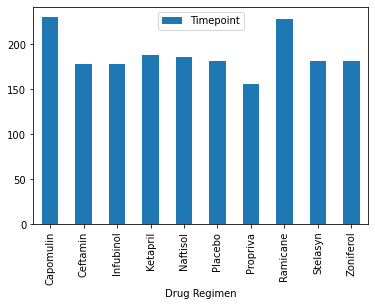

In [9]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas. 

combined_df.loc[:,["Drug Regimen", "Timepoint"]].groupby("Drug Regimen").count().plot(kind = "bar")

<BarContainer object of 10 artists>

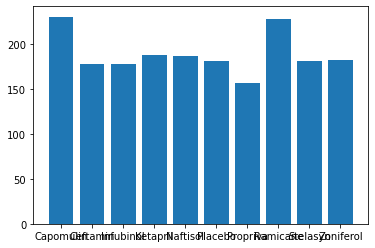

In [26]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
plt.bar(x = combined_df.loc[:,["Drug Regimen", "Timepoint"]].groupby("Drug Regimen").count().index, height = combined_df.loc[:,["Drug Regimen", "Timepoint"]].groupby("Drug Regimen").count()["Timepoint"])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002613DDF48D0>,
      dtype=object)

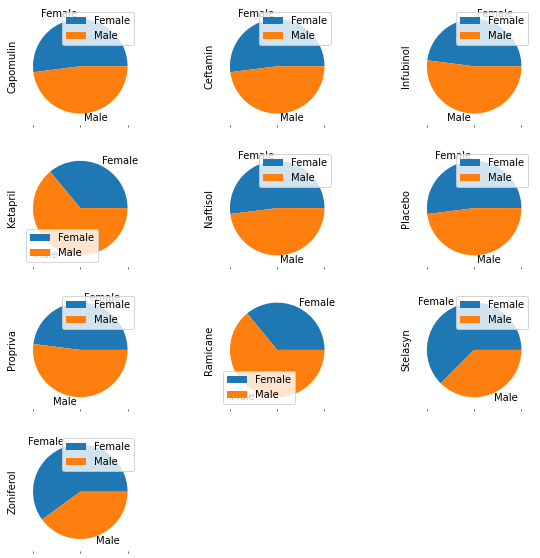

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
mouse_metadata_df.groupby(["Drug Regimen"])["Sex"].value_counts().unstack("Drug Regimen").plot(kind = "pie", subplots = True, layout = (4,-1), figsize = (10,10))


([<matplotlib.patches.Wedge at 0x2614266c940>,
 [Text(-0.0069391759767656585, 1.0999781124353174, 'Male'),
  Text(0.006939175976765524, -1.0999781124353174, 'Female')])

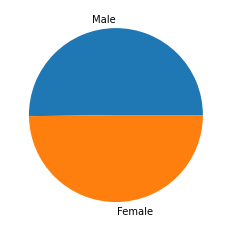

In [31]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(x= mouse_metadata_df["Sex"].value_counts(), labels = mouse_metadata_df["Sex"].value_counts().index )


## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
drugs = [ "Capomulin", "Ramicane", "Infubinol", "Ceftamin" ]
gby = combined_df.groupby(["Drug Regimen", "Mouse ID"])

# Start by getting the last (greatest) timepoint for each mouse
idx = gby["Timepoint"].transform(max) == combined_df["Timepoint"]

# Use this to filter the original dataframe to get the tumor volume at the last timepoint
tumor_v_df = combined_df[idx][combined_df["Drug Regimen"].isin(drugs)]

tumor_v_df.set_index(["Drug Regimen", "Mouse ID"]).loc[:,["Timepoint", "Tumor Volume (mm3)"]].sort_index(ascending = True)

ipykernel_launcher:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Timepoint  Tumor Volume (mm3)
Drug Regimen Mouse ID                               
Capomulin    b128             45           38.982878
             b742             45           38.939633
             f966             20           30.485985
             g288             45           37.074024
             g316             45           40.159220
...                          ...                 ...
Ramicane     s508             45           30.276232
             u196             45           40.667713
             w678              5           43.166373
             y449             15           44.183451
             z578             45           30.638696

[100 rows x 2 columns]

In [14]:
# Calculate the quartiles
all_outliers = []
for drug in drugs:
    drug_s = tumor_v_df[tumor_v_df["Drug Regimen"] == drug]
    q1 = drug_s["Tumor Volume (mm3)"].quantile(0.25)
    q2 = drug_s["Tumor Volume (mm3)"].quantile(0.50)
    q3 = drug_s["Tumor Volume (mm3)"].quantile(0.75)

    # Calculate the IQR and quantitatively determine if there are any potential outliers across all four treatment regimens.
    iqr = q3-q1
    outliers = drug_s.query('~((@q1 - 1.5 * @iqr) <= `Tumor Volume (mm3)` <= (@q3 + 1.5 * @iqr) )')
    all_outliers.append(outliers)
pd.concat(all_outliers)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
669,c326,Infubinol,Female,18,25,5,36.321346,0


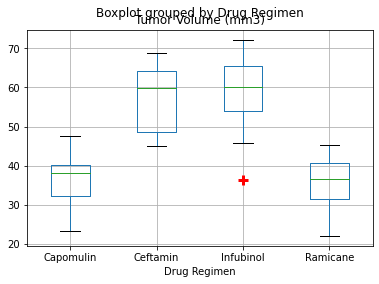

In [15]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

tumor_v_df.boxplot(column = "Tumor Volume (mm3)", by = "Drug Regimen", flierprops = {"mec" : "red", "mew" : 3, "marker" : "+", "ms" : 10})

## Line and Scatter Plots

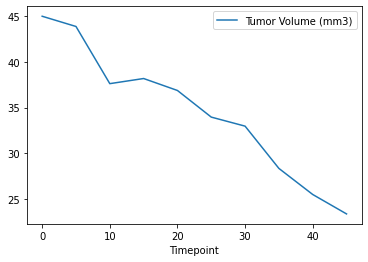

In [16]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin

cap_mouse = combined_df[combined_df["Drug Regimen"] == "Capomulin"].iloc[0]["Mouse ID"]
combined_df[combined_df["Mouse ID"] == cap_mouse].plot(x = "Timepoint", y = "Tumor Volume (mm3)")



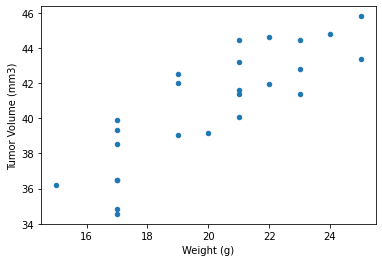

In [17]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
cap_means = combined_df[combined_df["Drug Regimen"] == "Capomulin"].groupby("Mouse ID").mean()
cap_means.plot(x = "Weight (g)", y = "Tumor Volume (mm3)", kind = "scatter")

## Correlation and Regression

In [18]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
x = cap_means["Weight (g)"]
y = cap_means["Tumor Volume (mm3)"]
n = len(x)
ave_x = x.mean()
ave_y = y.mean()
slope = ( ((x - ave_x) * (y - ave_y)).sum() / ((x - ave_x)**2).sum() )
incpt = ave_y - (slope * ave_x)
